## univariate prediction for kyoto

In [39]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [40]:
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 2a4477f5-bb85-4b37-927b-5c4a7a0ce954)')' thrown while requesting HEAD https://huggingface.co/api/resolve-cache/models/amazon/chronos-2/e19c427c73837c00b5e932da5fbfede2929677ce/config.json
Retrying in 1s [Retry 1/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 8c2a7b82-cb91-4997-9d1d-126f85628c52)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/model.safetensors
Retrying in 1s [Retry 1/5].


## Univariate Forecasting


In [349]:
df = pd.read_csv('data/kyoto.csv')#,index_col='year')
df = df[df['year']>1677]
df.reset_index(drop=True)

,location,lat,long,alt,year,bloom_date,bloom_doy,spring_temp,spring_gdd,winter_chill_days,spring_precip
0,kyoto,35.011983,135.676114,44,1678,1678-04-19,109,NaN,NaN,NaN,NaN
1,kyoto,35.011983,135.676114,44,1679,1679-04-24,114,NaN,NaN,NaN,NaN
2,kyoto,35.011983,135.676114,44,1680,1680-04-18,109,NaN,NaN,NaN,NaN
3,kyoto,35.011983,135.676114,44,1681,1681-04-20,110,NaN,NaN,NaN,NaN
4,kyoto,35.011983,135.676114,44,1682,1682-04-14,104,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
333,kyoto,35.011983,135.676114,44,2020,2020-04-01,92,7.02,212.5,58.0,279.0
334,kyoto,35.011983,135.676114,44,2021,2021-03-26,85,6.58,233.4,63.0,286.3
335,kyoto,35.011983,135.676114,44,2022,2022-04-01,91,4.65,129.1,79.0,163.0
336,kyoto,35.011983,135.676114,44,2023,2023-03-25,84,6.27,220.5,74.0,223.9


In [350]:
year = df['year'].values
day = df['bloom_doy'].values
print(year, day)

[1678 1679 1680 1681 1682 1683 1684 1685 1686 1687 1688 1689 1690 1691
 1692 1693 1694 1695 1696 1697 1698 1699 1700 1701 1702 1703 1704 1705
 1706 1707 1708 1709 1713 1714 1715 1716 1717 1718 1719 1720 1721 1722
 1723 1724 1725 1726 1727 1728 1729 1731 1732 1733 1734 1735 1736 1737
 1738 1739 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749 1750 1751
 1752 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764 1765
 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778 1779
 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 1792 1793
 1794 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805 1806 1807
 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819 1820 1821
 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833 1834 1835
 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847 1848 1849
 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863
 1864 1865 1866 1867 1868 1869 1870 1871 1873 1874 1875 1876 1877 1878
 1879 

In [351]:
year_interp = np.arange(year.min(), year.max()+1)
day_interp = np.interp(year_interp,year,day)

In [352]:
new_df = pd.DataFrame({'timestamp':year_interp, 'target':day_interp, 'item_id':np.ones(len(day_interp))})
new_df['timestamp'] = pd.to_datetime(new_df['timestamp'],format='%Y')
#new_df['target'] = interp_day
#new_df['item_id'] = np.ones(len(interp_day),dtype=object)

In [353]:
new_df

,timestamp,target,item_id
0,1678-01-01,109.0,1.0
1,1679-01-01,114.0,1.0
2,1680-01-01,109.0,1.0
3,1681-01-01,110.0,1.0
4,1682-01-01,104.0,1.0
...,...,...,...
342,2020-01-01,92.0,1.0
343,2021-01-01,85.0,1.0
344,2022-01-01,91.0,1.0
345,2023-01-01,84.0,1.0


In [354]:
pred_df = pipeline.predict_df(new_df[:-12], prediction_length=24, quantile_levels=[0.1, 0.5, 0.9])
pred_df

,item_id,timestamp,target_name,predictions,0.1,0.5,0.9
0,1.0,2013-01-01,target,96.479691,91.875046,96.479691,101.463303
1,1.0,2014-01-01,target,96.291428,91.685333,96.291428,101.334785
2,1.0,2015-01-01,target,96.317177,91.769104,96.317177,101.314102
3,1.0,2016-01-01,target,96.348145,91.747902,96.348145,101.425713
4,1.0,2017-01-01,target,96.277679,91.615005,96.277679,101.366493
5,1.0,2018-01-01,target,96.170166,91.464584,96.170166,101.391876
6,1.0,2019-01-01,target,96.060921,91.405800,96.060921,101.275650
7,1.0,2020-01-01,target,96.048660,91.350540,96.048660,101.285133
8,1.0,2021-01-01,target,95.916634,91.206078,95.916634,101.071709
9,1.0,2022-01-01,target,95.706497,91.178825,95.706497,100.791458


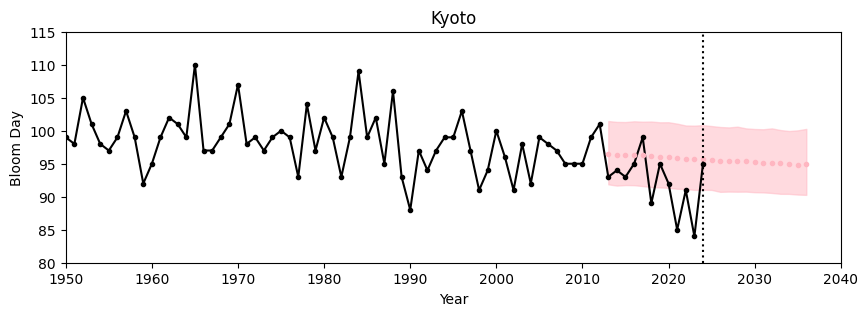

In [374]:
plt.figure(figsize=(10,3))
plt.plot(new_df['timestamp'].dt.year,new_df['target'],'k.-')
#plt.plot(pred_df['timestamp'],pred_df['predictions'],'.',c='lightpink')
plt.plot(pred_df['timestamp'].dt.year,pred_df['0.5'],'.',lw=2,c='lightpink')
plt.fill_between(pred_df['timestamp'].dt.year,pred_df['0.1'],y2=pred_df['0.9'],color='lightpink',alpha=0.5)
plt.axvline(x=2024,ls=':',c='k')
plt.xlabel('Year')
plt.ylabel('Bloom Day')
plt.xlim([1950,2040])
plt.ylim([80,115])
plt.title('Kyoto')
plt.savefig('kyoto_pred.pdf')

## Forecasting with Covariates

In [356]:
df_cov = pd.read_csv('data/by_city/japan_Japan_Kyoto.csv')
df_cov

,location,lat,long,alt,year,bloom_date,bloom_doy,spring_temp,spring_gdd,winter_chill_days,spring_precip
0,Japan/Kyoto,35.014722,135.732778,40.81,1953,1953-04-11,101,4.55,105.5,79.0,170.4
1,Japan/Kyoto,35.014722,135.732778,40.81,1954,1954-04-05,95,5.15,124.0,68.0,193.3
2,Japan/Kyoto,35.014722,135.732778,40.81,1955,1955-04-07,97,4.42,102.0,81.0,213.7
3,Japan/Kyoto,35.014722,135.732778,40.81,1956,1956-04-10,101,4.00,101.2,77.0,274.6
4,Japan/Kyoto,35.014722,135.732778,40.81,1957,1957-04-12,102,3.83,52.8,80.0,178.4
...,...,...,...,...,...,...,...,...,...,...,...
64,Japan/Kyoto,35.014722,135.732778,40.81,2017,2017-04-07,97,4.51,74.7,71.0,191.5
65,Japan/Kyoto,35.014722,135.732778,40.81,2018,2018-03-28,87,4.82,148.9,84.0,255.0
66,Japan/Kyoto,35.014722,135.732778,40.81,2019,2019-04-06,96,5.62,129.7,72.0,190.1
67,Japan/Kyoto,35.014722,135.732778,40.81,2020,2020-03-30,90,6.94,207.0,59.0,279.0


In [367]:
## interpolate the missing years

year = df_cov['year'].values
year_interp = np.arange(year.min(), 2024)

new_df_cov = pd.DataFrame({'timestamp':year_interp})

useful_cols = ['bloom_doy','spring_temp','spring_gdd','winter_chill_days','spring_precip']

for c in useful_cols:
    val_interp = np.interp(year_interp,year,df_cov[c].values)
    new_df_cov[c+'_interp'] = val_interp

new_df_cov['item_id'] = np.ones(len(val_interp),dtype=object)
new_df_cov['timestamp'] = pd.to_datetime(new_df_cov['timestamp'],format='%Y')
new_df_cov

,timestamp,bloom_doy_interp,spring_temp_interp,spring_gdd_interp,winter_chill_days_interp,spring_precip_interp,item_id
0,1953-01-01,101.0,4.55,105.5,79.0,170.4,1
1,1954-01-01,95.0,5.15,124.0,68.0,193.3,1
2,1955-01-01,97.0,4.42,102.0,81.0,213.7,1
3,1956-01-01,101.0,4.00,101.2,77.0,274.6,1
4,1957-01-01,102.0,3.83,52.8,80.0,178.4,1
...,...,...,...,...,...,...,...
66,2019-01-01,96.0,5.62,129.7,72.0,190.1,1
67,2020-01-01,90.0,6.94,207.0,59.0,279.0,1
68,2021-01-01,85.0,6.49,228.3,65.0,286.3,1
69,2022-01-01,85.0,6.49,228.3,65.0,286.3,1


In [368]:
pred_df_cov = pipeline.predict_df(
    new_df_cov[:-12],
    prediction_length=24,
    quantile_levels=[0.1, 0.5, 0.9],
    target='bloom_doy_interp',
)

In [369]:
pred_df_cov

,item_id,timestamp,target_name,predictions,0.1,0.5,0.9
0,1,2012-01-01,bloom_doy_interp,95.830330,90.869186,95.830330,100.733040
1,1,2013-01-01,bloom_doy_interp,95.920532,90.836533,95.920532,100.943192
2,1,2014-01-01,bloom_doy_interp,95.888733,90.807602,95.888733,100.955017
3,1,2015-01-01,bloom_doy_interp,95.945816,90.824753,95.945816,100.995300
4,1,2016-01-01,bloom_doy_interp,95.971474,90.804489,95.971474,101.054504
5,1,2017-01-01,bloom_doy_interp,96.058388,90.849419,96.058388,101.174698
6,1,2018-01-01,bloom_doy_interp,96.036987,90.811874,96.036987,101.174400
7,1,2019-01-01,bloom_doy_interp,96.008774,90.822144,96.008774,101.158669
8,1,2020-01-01,bloom_doy_interp,96.032677,90.762146,96.032677,101.156219
9,1,2021-01-01,bloom_doy_interp,96.122269,90.813515,96.122269,101.284508


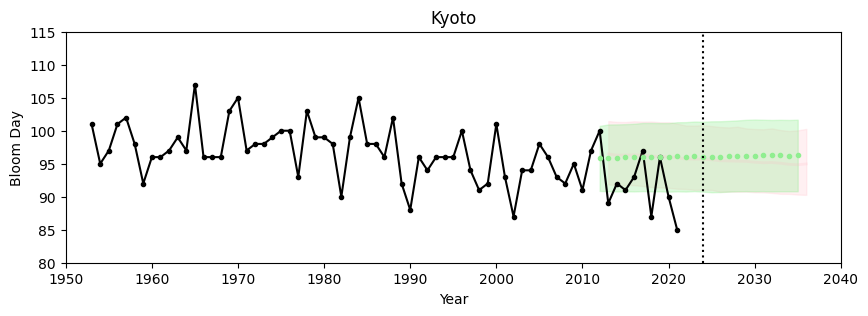

In [375]:
plt.figure(figsize=(10,3))
plt.plot(df_cov['year'],df_cov['bloom_doy'],'k.-')
plt.plot(pred_df['timestamp'].dt.year,pred_df['0.5'],'-',lw=2,c='lightpink',alpha=0.2)
plt.fill_between(pred_df['timestamp'].dt.year,pred_df['0.1'],y2=pred_df['0.9'],color='lightpink',alpha=0.2)
plt.plot(pred_df_cov['timestamp'].dt.year,pred_df_cov['0.5'],'.',lw=2,c='lightgreen')
plt.fill_between(pred_df_cov['timestamp'].dt.year,pred_df_cov['0.1'],y2=pred_df_cov['0.9'],color='lightgreen',alpha=0.3)
plt.axvline(x=2024,ls=':',c='k')
plt.xlabel('Year')
plt.ylabel('Bloom Day')
plt.ylim([80,115])
plt.xlim([1950,2040])
plt.title('Kyoto')
plt.savefig('kyoto_pred_cov.pdf')